In [1]:
import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict

sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research')
from prelim_experiments.param_experiments.chaney_utils import (
    load_sim_results,
    graph_relative_to_ideal,
    merge_results,
    graph_metrics,
    graph_metrics_by_axis,
    graph_relative_to_global_by_axis,
    transform_relative_to_global,
    graph_histogram_metric_by_axis,
    graph_averaged_metric_by_axis,
    graph_metrics_difference_by_axis
)
from wrapper.models.bubble import BubbleBurster
from src.utils import compute_constrained_clusters, create_global_user_pairs, user_topic_mapping, create_cluster_user_pairs, load_and_process_movielens, compute_embeddings
from wrapper.metrics.clustering_metrics import MeanCosineSim, MeanDistanceFromCentroid, MeanCosineSimPerCluster, MeanDistanceFromCentroidPerCluster
from prelim_experiments.param_experiments.chaney_utils import *

import warnings
warnings.simplefilter("ignore")

import itertools
import os

/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research/prelim_experiments/param_experiments/chaney_utils.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if model_key is "ideal" and not absolute_measure:


In [2]:
results_paths = ["all_sim_results/1simulation/repeated_training"]
results_files = ["sim_results.pkl"]
# environment_file = ["sim_environment.pkl"]
# diagnostics_file = ["sim_diagnostics.pkl"]

repeated_training_results = merge_results(results_paths, results_files)

print(len(repeated_training_results.keys()), repeated_training_results.keys())
print(len(repeated_training_results["mse"].keys()), repeated_training_results["mse"].keys())
print(len(repeated_training_results["mean_global_cosine_sim"]["xquad_binary_0.25"]), "= # simulations")
print(len(repeated_training_results["mean_global_cosine_sim"]["xquad_binary_0.25"][0]), "= # timesteps/simulation")

19 dict_keys(['mse', 'interaction_spread', 'global_interaction_similarity', 'inter_cluster_interaction_similarity', 'intra_cluster_interaction_similarity', 'mean_global_cosine_sim', 'mean_intra_cluster_cosine_sim', 'mean_inter_cluster_cosine_sim', 'mean_cosine_sim_per_cluster', 'mean_cluster_distance_from_centroid', 'mean_global_distance_from_centroid', 'mean_distance_from_centroid_per_cluster', 'interaction_histogram', 'rmse', 'mean_novelty', 'mean_slate_topic_diversity', 'topic_interaction_histogram', 'topic_interaction_spread', 'mse_per_user'])
9 dict_keys(['baseline_myopic', 'repeated_items_repeat_interactions', 'probabilistic', 'random', 'random_interleaving', 'xquad_binary_0.1', 'xquad_binary_0.25', 'xquad_smooth_0.1', 'xquad_smooth_0.25'])
1 = # simulations
100 = # timesteps/simulation


In [3]:
results_paths = ["all_sim_results/1simulation/single_training"]
results_files = ["sim_results.pkl"]
# environment_file = ["sim_environment.pkl"]
# diagnostics_file = ["sim_diagnostics.pkl"]

single_training_results = merge_results(results_paths, results_files)

print(len(repeated_training_results.keys()), repeated_training_results.keys())
print(len(repeated_training_results["mse"].keys()), repeated_training_results["mse"].keys())
print(len(repeated_training_results["mean_global_cosine_sim"]["xquad_binary_0.25"]), "= # simulations")
print(len(repeated_training_results["mean_global_cosine_sim"]["xquad_binary_0.25"][0]), "= # timesteps/simulation")

19 dict_keys(['mse', 'interaction_spread', 'global_interaction_similarity', 'inter_cluster_interaction_similarity', 'intra_cluster_interaction_similarity', 'mean_global_cosine_sim', 'mean_intra_cluster_cosine_sim', 'mean_inter_cluster_cosine_sim', 'mean_cosine_sim_per_cluster', 'mean_cluster_distance_from_centroid', 'mean_global_distance_from_centroid', 'mean_distance_from_centroid_per_cluster', 'interaction_histogram', 'rmse', 'mean_novelty', 'mean_slate_topic_diversity', 'topic_interaction_histogram', 'topic_interaction_spread', 'mse_per_user'])
9 dict_keys(['baseline_myopic', 'repeated_items_repeat_interactions', 'probabilistic', 'random', 'random_interleaving', 'xquad_binary_0.1', 'xquad_binary_0.25', 'xquad_smooth_0.1', 'xquad_smooth_0.25'])
1 = # simulations
100 = # timesteps/simulation


In [4]:
model_keys = ['baseline_myopic', 'repeated_items_repeat_interactions', 'probabilistic', 'random', 'random_interleaving', 'xquad_binary_0.1', 'xquad_binary_0.25', 'xquad_smooth_0.1', 'xquad_smooth_0.25']

id_to_readable = {
    'baseline_myopic':'Myopic recommender',
    'repeated_items_repeat_interactions':'Repeat items/interactions recommender',
    'probabilistic':'Probabilistic recommender',
    'random':'Random Recommender',
    'random_interleaving':'Random interleaving recommender',
    'xquad_binary_0.1':'xQuaD Binary (alpha=0.1)',
    'xquad_binary_0.25':'xQuaD Binary (alpha=0.25)',
    'xquad_smooth_0.1':'xQuaD Smooth (alpha=0.1)',
    'xquad_smooth_0.25':'xQuaD Smooth (alpha=0.25)',
}

y_labels = dict([
    ("mse", "mse"), 
    ("interaction_spread", "item interaction spread"), 
    ("global_interaction_similarity", "average jacard similarity"), 
    ("inter_cluster_interaction_similarity", "average jacard similarity"), 
    ("intra_cluster_interaction_similarity", "average jacard similarity"), 
    ("mean_global_cosine_sim", "average cosine sim"),
    ("mean_intra_cluster_cosine_sim", "average cosine sim"),
    ("mean_inter_cluster_cosine_sim", "average cosine sim"),
    ("mean_cosine_sim_per_cluster", "average cosine sim"),
    ("mean_cluster_distance_from_centroid", "distance"),
    ("mean_global_distance_from_centroid", "distance"),
    ("mean_distance_from_centroid_per_cluster", "distance"),
    ("interaction_histogram", "No. interactions per item"),
    ("rmse", "rmse"),
    ("mean_novelty", "average novelty"),
    ("mean_slate_topic_diversity", "average topic diversity across rec slates"),
    ("topic_interaction_histogram", "No. interactions per topic"),
    ("topic_interaction_spread", "topic interaction spread"),
    ("mse_per_user", "mse per user")
])

# Graphing `mse`

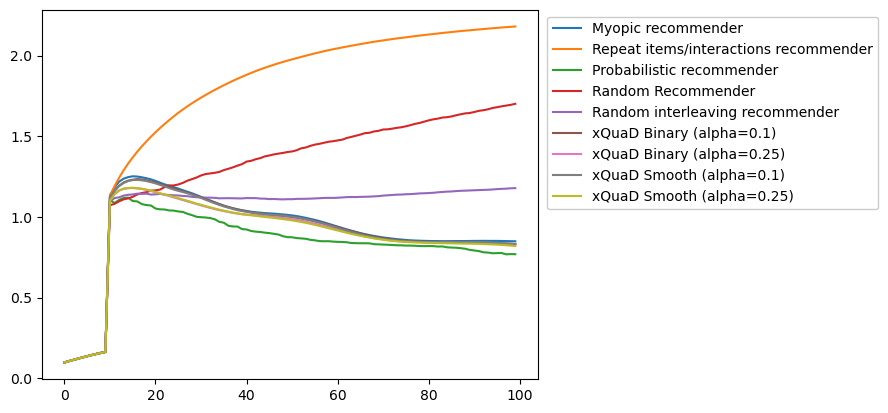

In [5]:
metric_key = "mse"

from prelim_experiments.param_experiments.chaney_utils import graph_metrics as chaney_graph_metrics

chaney_graph_metrics(repeated_training_results, metric_key, model_keys, id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0)

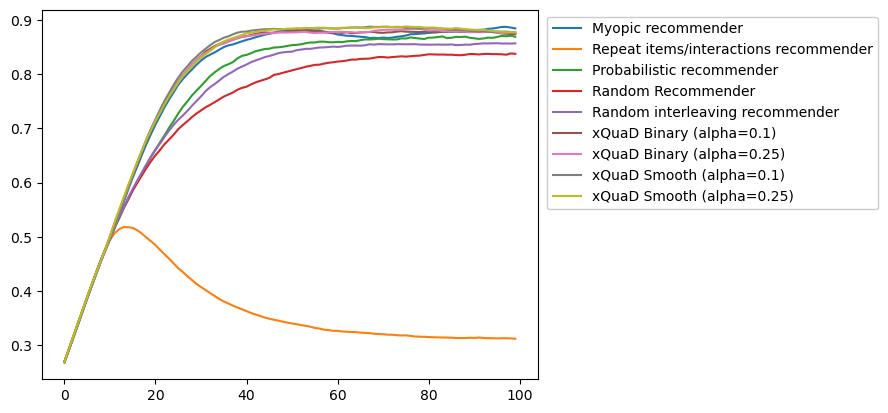

In [6]:
metric_key = "mean_intra_cluster_cosine_sim"
chaney_graph_metrics(repeated_training_results, metric_key, model_keys, id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0)

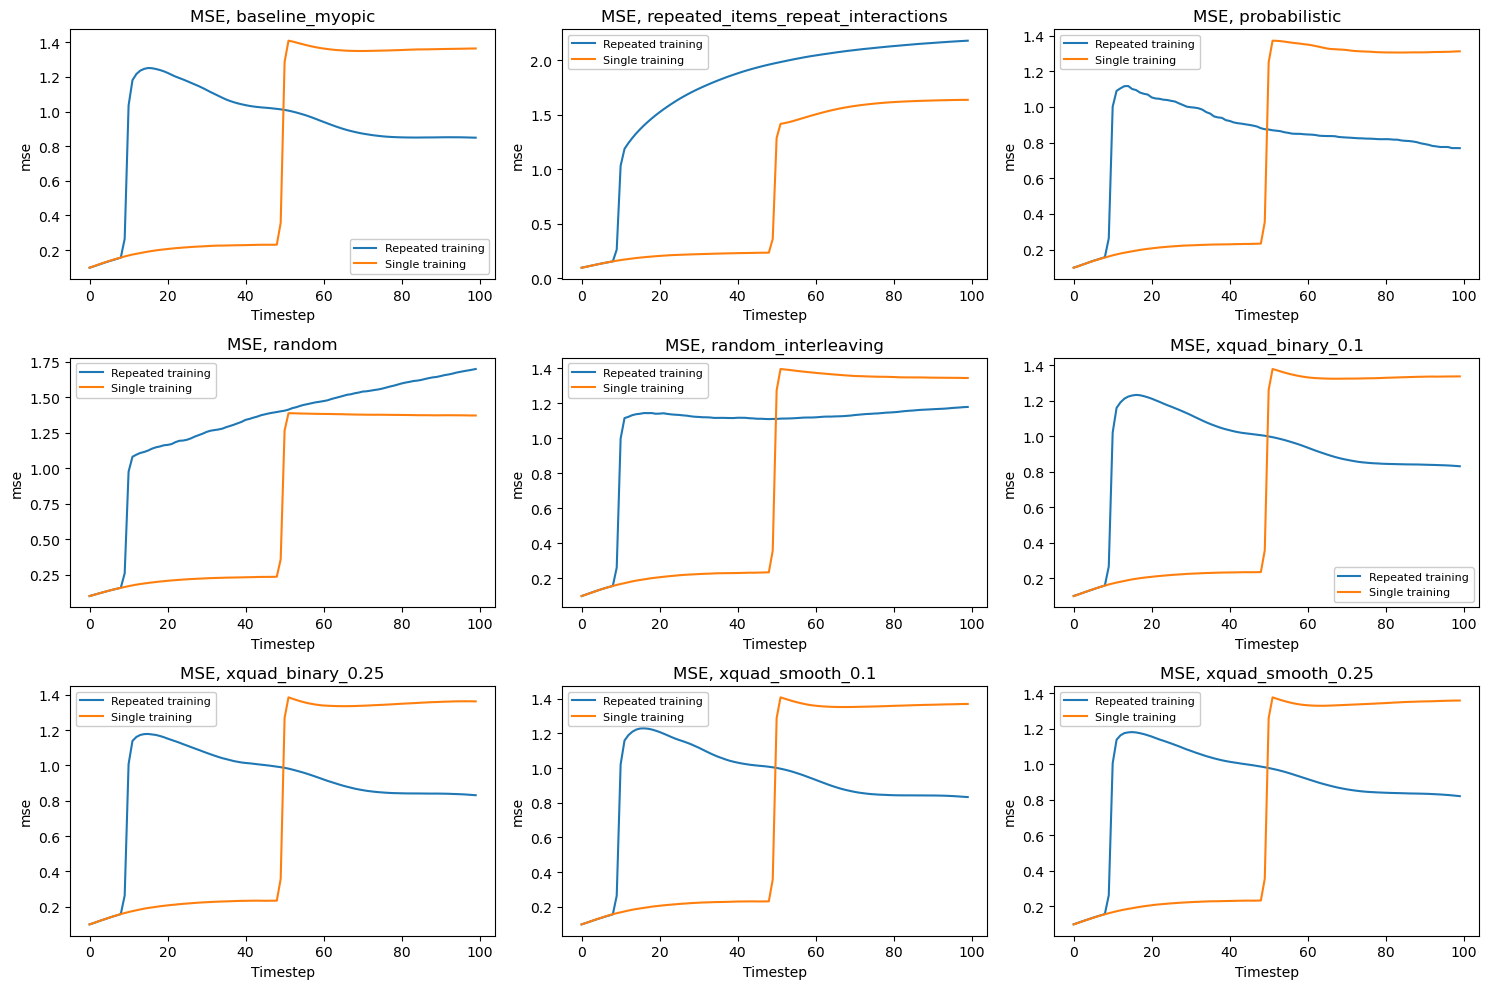

In [12]:
title = "MSE"
metric = "mse"

num_plots = len(model_keys)
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, model_key in enumerate(model_keys):
    curr_ax = axs[int(i/3), i%3]
    
    graph_metrics_by_axis(curr_ax, repeated_training_results, metric, [model_key], id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, label="Repeated training")
    graph_metrics_by_axis(curr_ax, single_training_results, metric, [model_key], id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, label="Single training")
    curr_ax.set_ylabel(y_labels[metric])
    curr_ax.set_xlabel("Timestep")
    # curr_ax.set_xlim(50, 100)
    curr_ax.set_title(f"{title}, {model_key}")
    curr_ax.legend(facecolor='white', framealpha=1, loc='best', fontsize="8",)

plt.tight_layout()

# graph_metrics_difference_by_axis(axs, repeated_training_results, numerator, denominator, model_keys, id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, normalized=False, label="by_params")
# axs.legend(facecolor='white', framealpha=1, loc='best', bbox_to_anchor=(0, 0))
# axs.plot(np.arange(100), np.zeros(100), linestyle='dashed')

# plt.tight_layout()

# Graphing `cosine similarity`

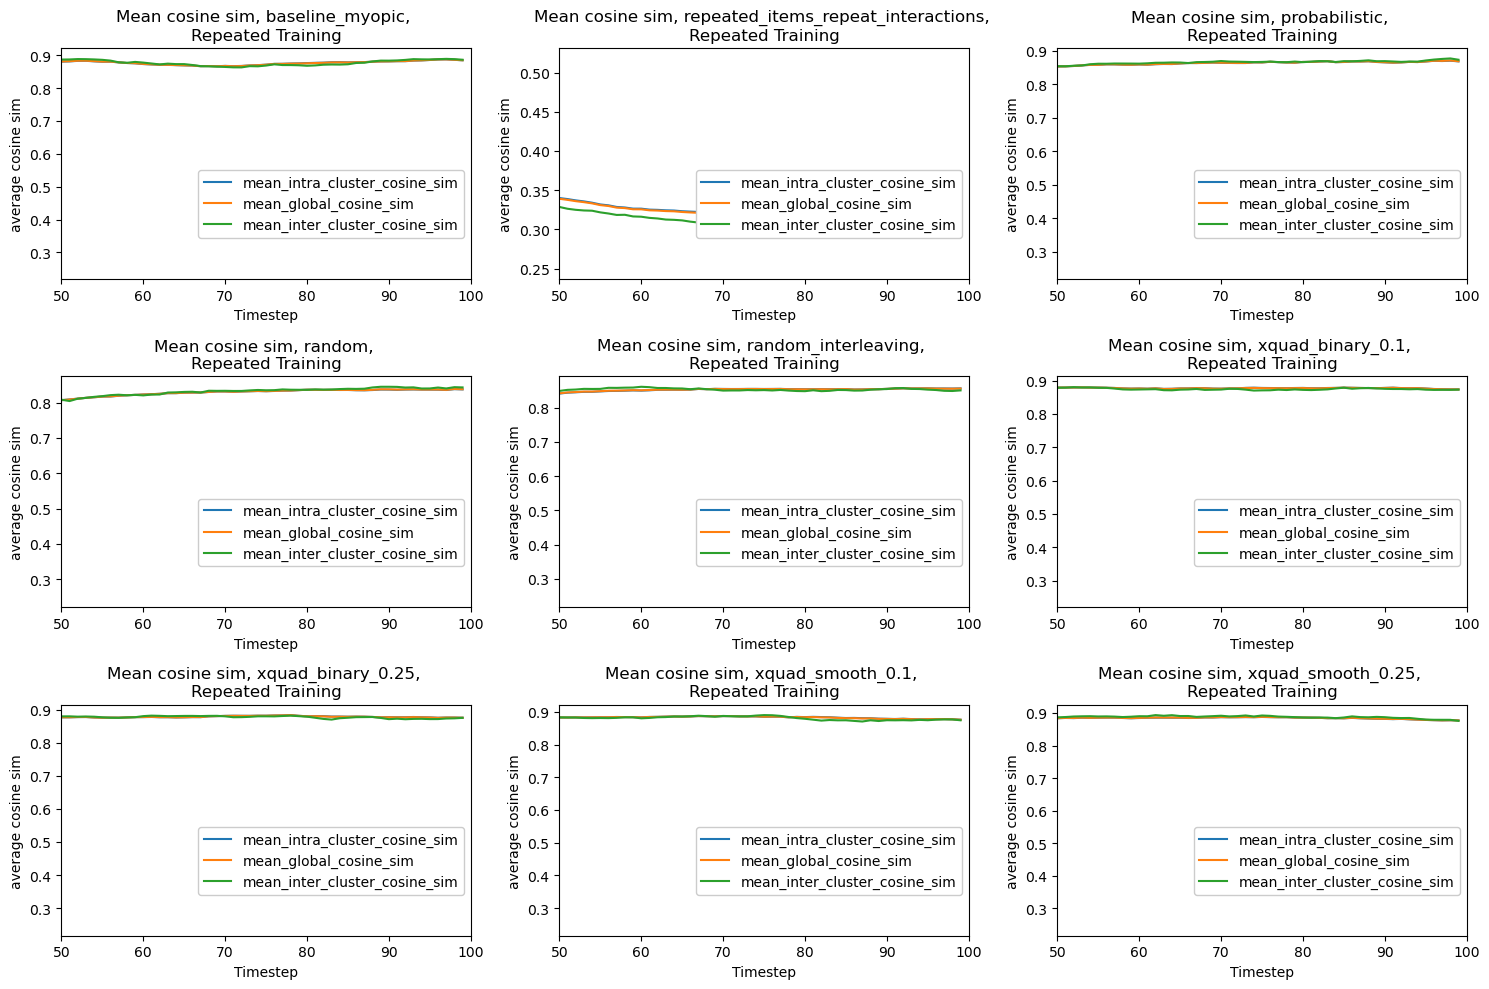

In [9]:
# Repeated training
title = "Mean cosine sim"
metric_keys = ["mean_intra_cluster_cosine_sim", "mean_global_cosine_sim", "mean_inter_cluster_cosine_sim"]
training_type = "Repeated Training"

num_plots = len(model_keys)
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, model_key in enumerate(model_keys):
    curr_ax = axs[int(i/3), i%3]
    # print(model_key)
    graph_metrics_by_axis(curr_ax, repeated_training_results, metric_keys[0], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    graph_metrics_by_axis(curr_ax, repeated_training_results, metric_keys[1], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    graph_metrics_by_axis(curr_ax, repeated_training_results, metric_keys[2], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    
    curr_ax.set_ylabel(y_labels[metric_keys[0]])
    curr_ax.set_xlabel("Timestep")
    curr_ax.set_xlim(50, 100)
    curr_ax.set_title(f"{title}, {model_key}, \n{training_type}")
    # curr_ax.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.25), fontsize="8",)

plt.tight_layout()

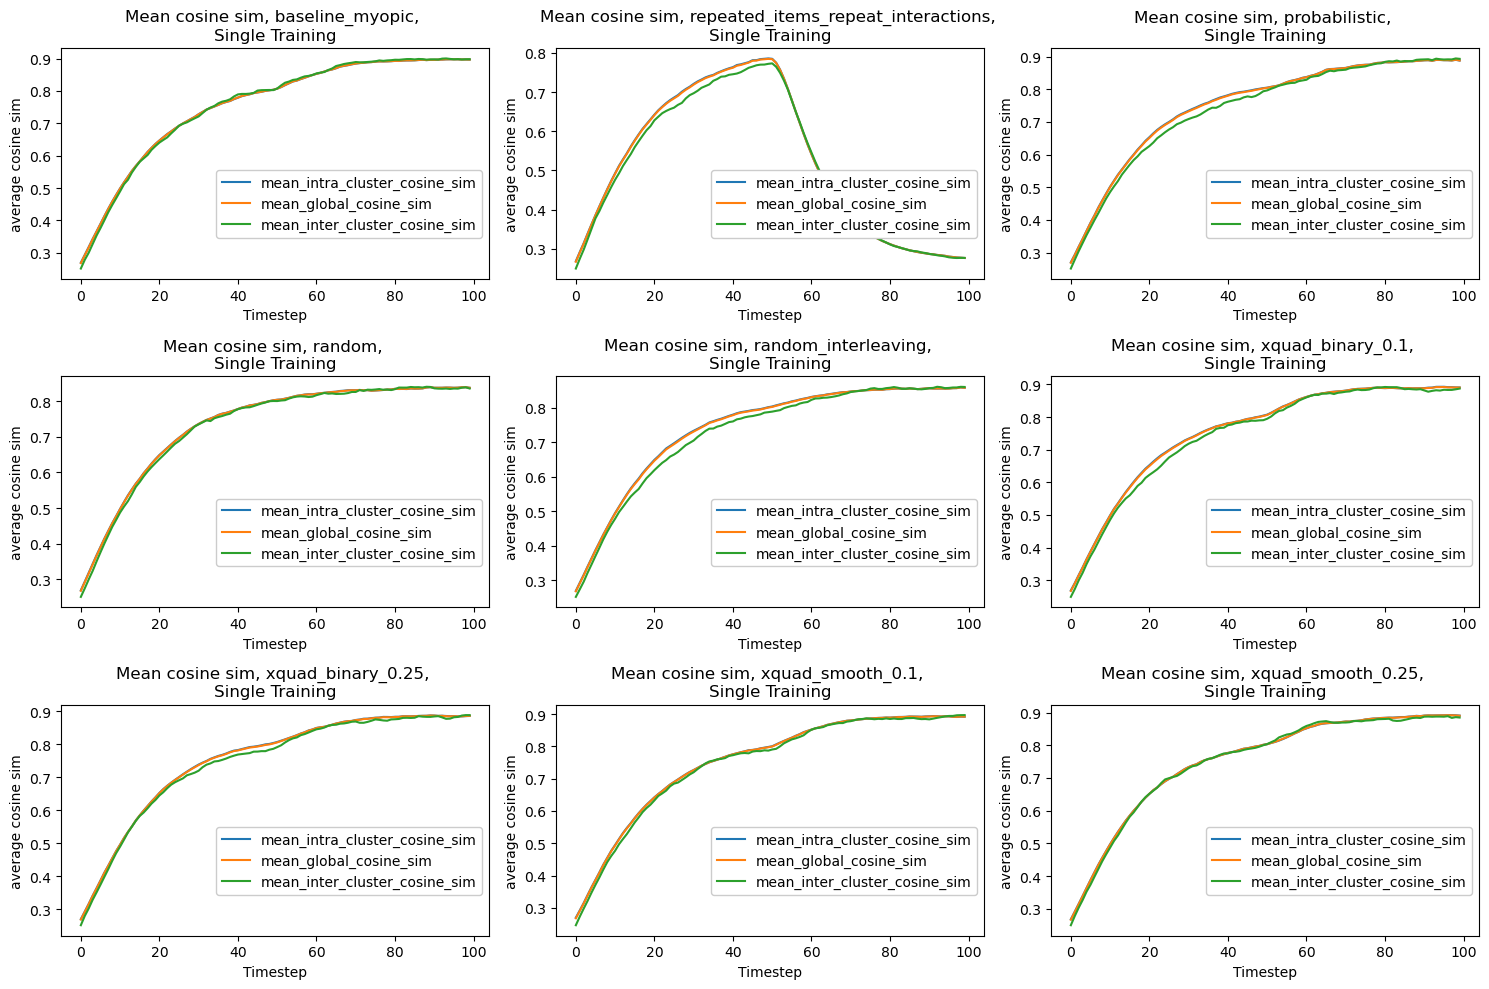

In [10]:
# Single training
title = "Mean cosine sim"
metric_keys = ["mean_intra_cluster_cosine_sim", "mean_global_cosine_sim", "mean_inter_cluster_cosine_sim"]
training_type = "Single Training"

num_plots = len(model_keys)
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, model_key in enumerate(model_keys):
    curr_ax = axs[int(i/3), i%3]
    # print(model_key)
    graph_metrics_by_axis(curr_ax, single_training_results, metric_keys[0], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    graph_metrics_by_axis(curr_ax, single_training_results, metric_keys[1], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    graph_metrics_by_axis(curr_ax, single_training_results, metric_keys[2], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    
    curr_ax.set_ylabel(y_labels[metric_keys[0]])
    curr_ax.set_xlabel("Timestep")
    # curr_ax.set_xlim(50, 100)
    curr_ax.set_title(f"{title}, {model_key}, \n{training_type}")
    # curr_ax.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.25), fontsize="8",)

plt.tight_layout()

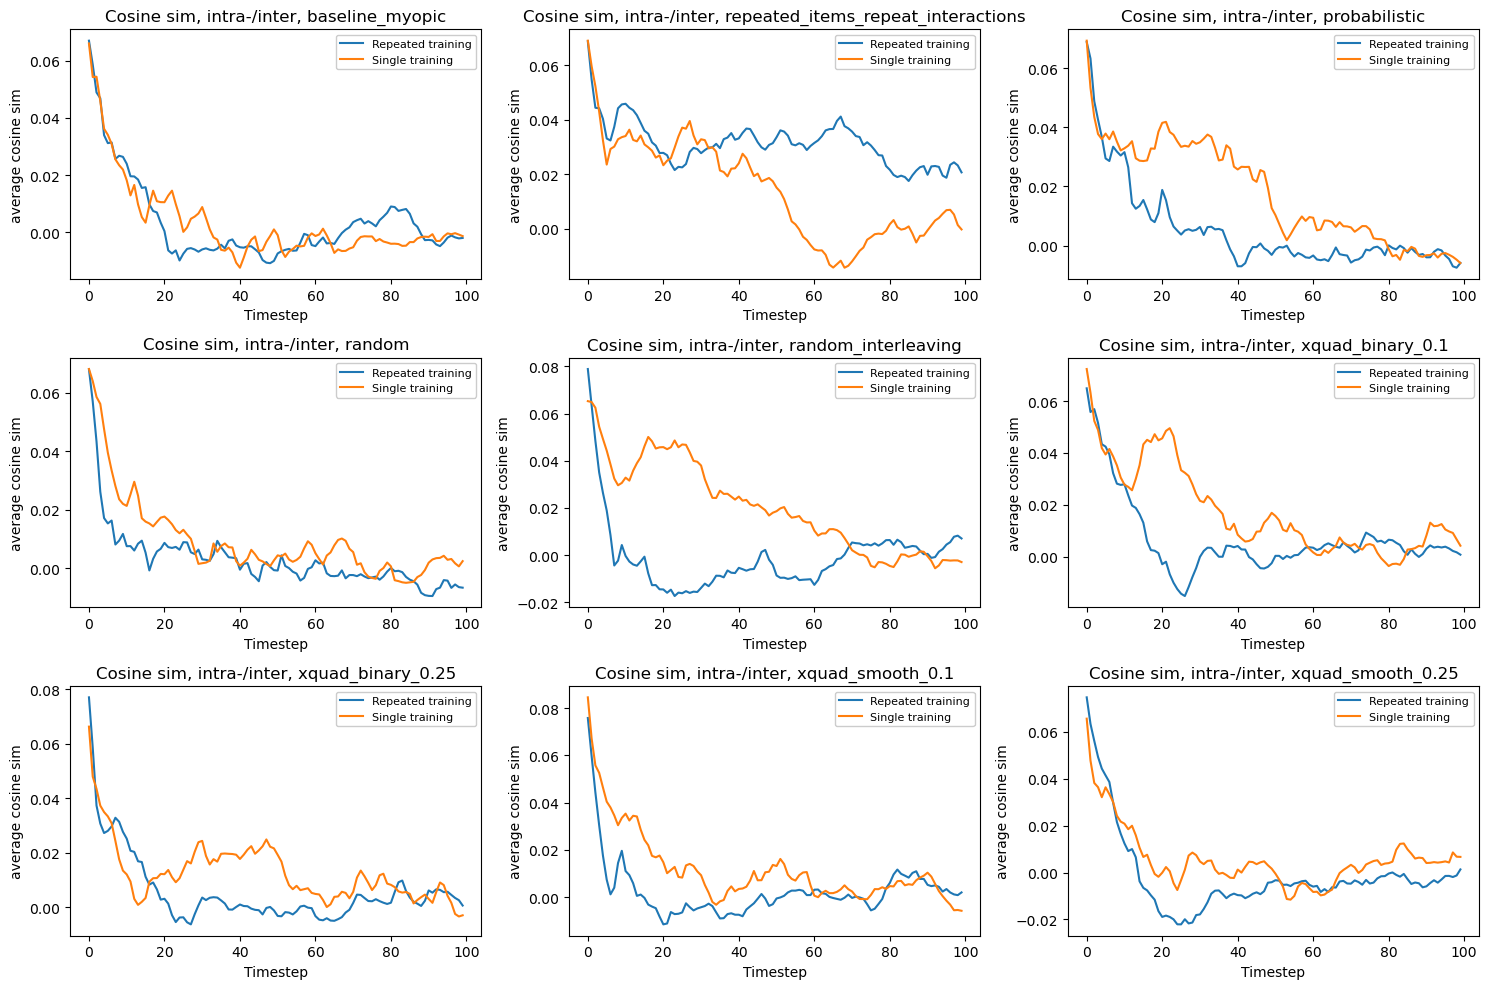

In [23]:
title = "Cosine sim, intra-/inter"
numerator = "mean_intra_cluster_cosine_sim"
denominator = "mean_inter_cluster_cosine_sim"

num_plots = len(model_keys)
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, model_key in enumerate(model_keys):
    curr_ax = axs[int(i/3), i%3]
    graph_metrics_difference_by_axis(curr_ax, repeated_training_results, numerator, denominator, [model_key], id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, normalized=True, label="Repeated training")
    graph_metrics_difference_by_axis(curr_ax, single_training_results, numerator, denominator, [model_key], id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, normalized=True, label="Single training")
    curr_ax.set_ylabel(y_labels[numerator])
    curr_ax.set_xlabel("Timestep")
    # curr_ax.set_xlim(50, 100)
    curr_ax.set_title(f"{title}, {model_key}")
    curr_ax.legend(facecolor='white', framealpha=1, loc='best', fontsize="8",)

plt.tight_layout()

# graph_metrics_difference_by_axis(axs, repeated_training_results, numerator, denominator, model_keys, id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, normalized=False, label="by_params")
# axs.legend(facecolor='white', framealpha=1, loc='best', bbox_to_anchor=(0, 0))
# axs.plot(np.arange(100), np.zeros(100), linestyle='dashed')

# plt.tight_layout()

# Graphing `interaction similarity`

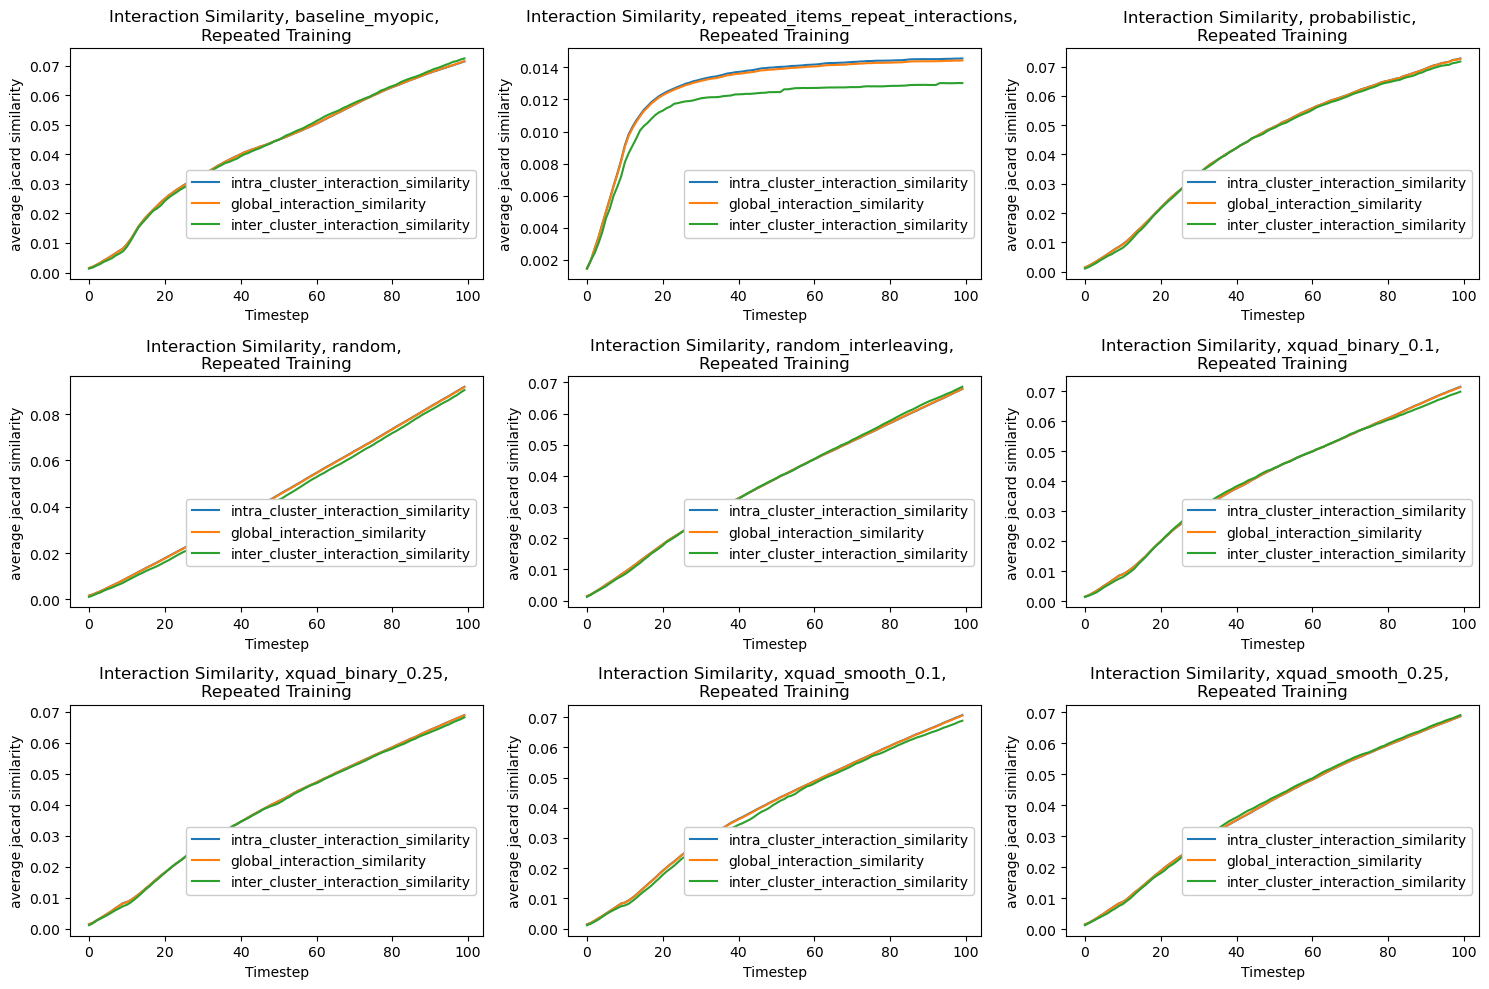

In [15]:
# Repeated training
title = "Interaction Similarity"
metric_keys = ["intra_cluster_interaction_similarity", "global_interaction_similarity", "inter_cluster_interaction_similarity"]
training_type = "Repeated Training"

num_plots = len(model_keys)
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, model_key in enumerate(model_keys):
    curr_ax = axs[int(i/3), i%3]
    # print(model_key)
    graph_metrics_by_axis(curr_ax, repeated_training_results, metric_keys[0], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    graph_metrics_by_axis(curr_ax, repeated_training_results, metric_keys[1], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    graph_metrics_by_axis(curr_ax, repeated_training_results, metric_keys[2], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    
    curr_ax.set_ylabel(y_labels[metric_keys[0]])
    curr_ax.set_xlabel("Timestep")
    # curr_ax.set_xlim(50, 100)
    curr_ax.set_title(f"{title}, {model_key}, \n{training_type}")
    # curr_ax.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.25), fontsize="8",)

plt.tight_layout()

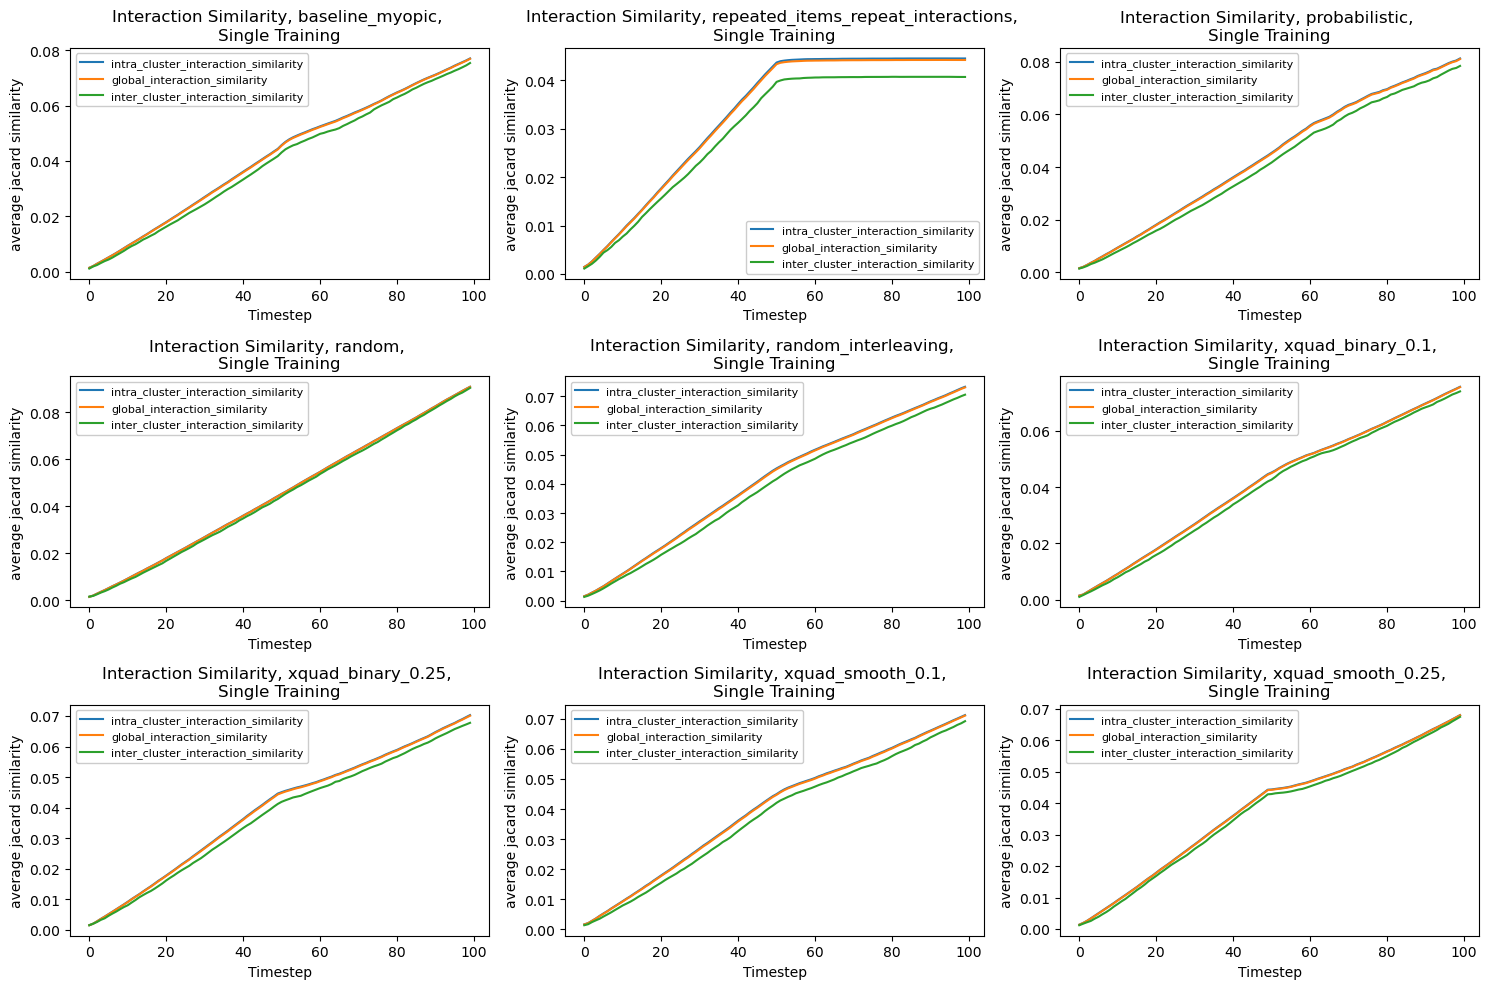

In [17]:
# Single training
title = "Interaction Similarity"
metric_keys = ["intra_cluster_interaction_similarity", "global_interaction_similarity", "inter_cluster_interaction_similarity"]
training_type = "Single Training"

num_plots = len(model_keys)
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, model_key in enumerate(model_keys):
    curr_ax = axs[int(i/3), i%3]
    # print(model_key)
    graph_metrics_by_axis(curr_ax, single_training_results, metric_keys[0], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    graph_metrics_by_axis(curr_ax, single_training_results, metric_keys[1], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    graph_metrics_by_axis(curr_ax, single_training_results, metric_keys[2], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    
    curr_ax.set_ylabel(y_labels[metric_keys[0]])
    curr_ax.set_xlabel("Timestep")
    # curr_ax.set_xlim(50, 100)
    curr_ax.set_title(f"{title}, {model_key}, \n{training_type}")
    curr_ax.legend(facecolor='white', framealpha=1, loc='best', fontsize="8",)

plt.tight_layout()

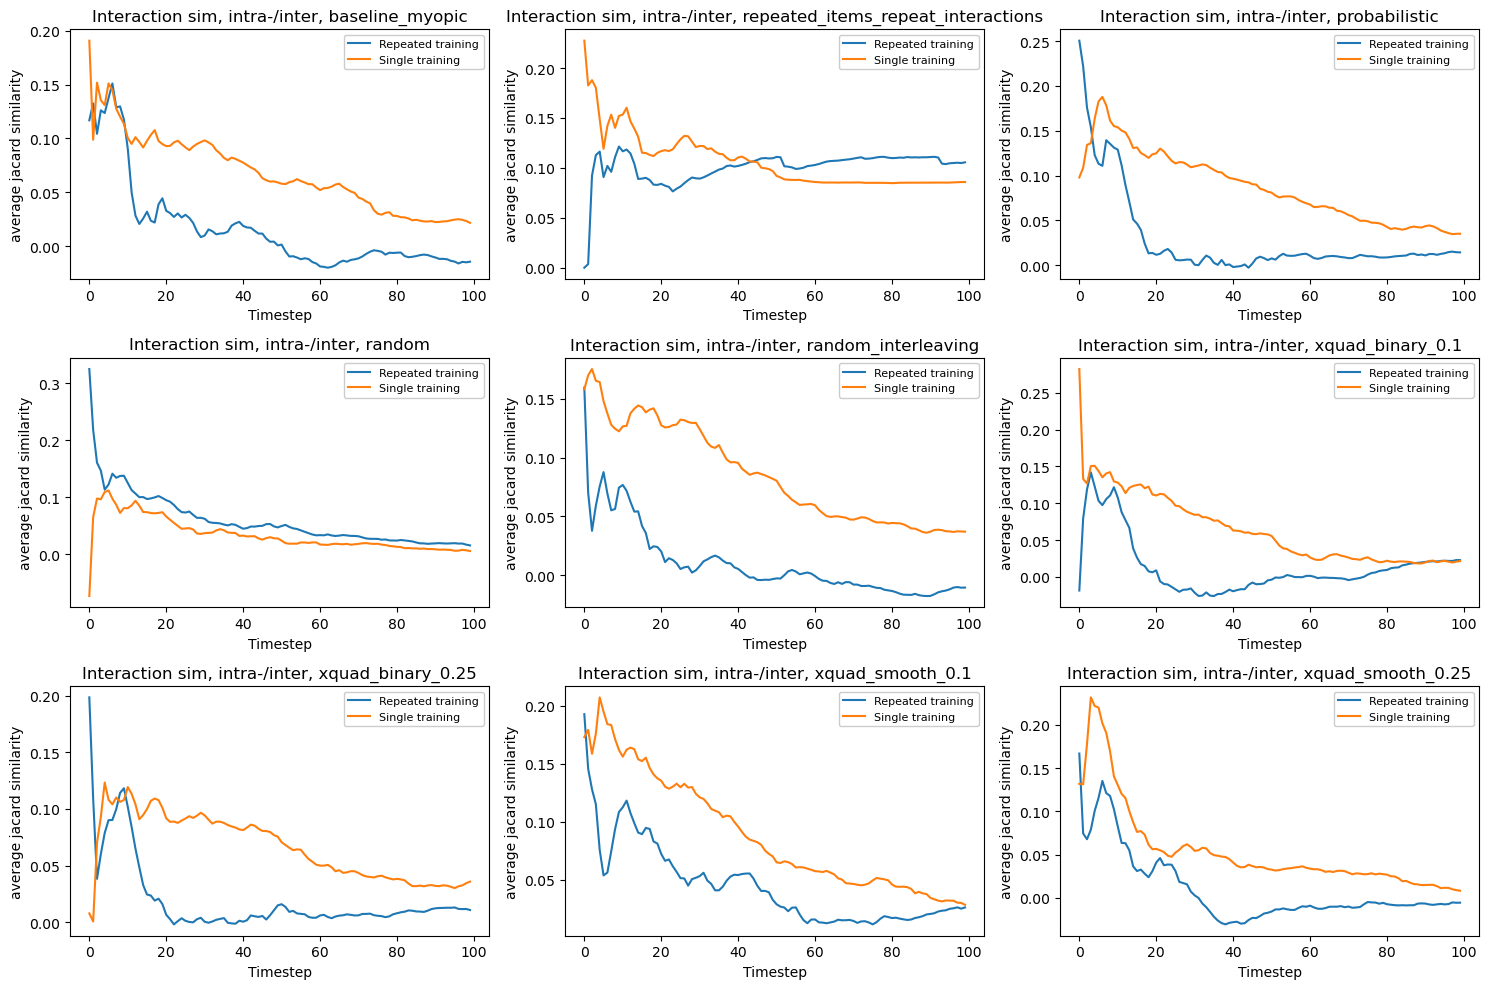

In [19]:
title = "Interaction sim, intra-/inter"
numerator = "intra_cluster_interaction_similarity"
denominator = "inter_cluster_interaction_similarity"

num_plots = len(model_keys)
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, model_key in enumerate(model_keys):
    curr_ax = axs[int(i/3), i%3]
    graph_metrics_difference_by_axis(curr_ax, repeated_training_results, numerator, denominator, [model_key], id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, normalized=True, label="Repeated training")
    graph_metrics_difference_by_axis(curr_ax, single_training_results, numerator, denominator, [model_key], id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, normalized=True, label="Single training")
    curr_ax.set_ylabel(y_labels[numerator])
    curr_ax.set_xlabel("Timestep")
    # curr_ax.set_xlim(50, 100)
    curr_ax.set_title(f"{title}, {model_key}")
    curr_ax.legend(facecolor='white', framealpha=1, loc='best', fontsize="8",)

plt.tight_layout()

# graph_metrics_difference_by_axis(axs, repeated_training_results, numerator, denominator, model_keys, id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, normalized=False, label="by_params")
# axs.legend(facecolor='white', framealpha=1, loc='best', bbox_to_anchor=(0, 0))
# axs.plot(np.arange(100), np.zeros(100), linestyle='dashed')

# plt.tight_layout()

# Graphing `cluster distance`

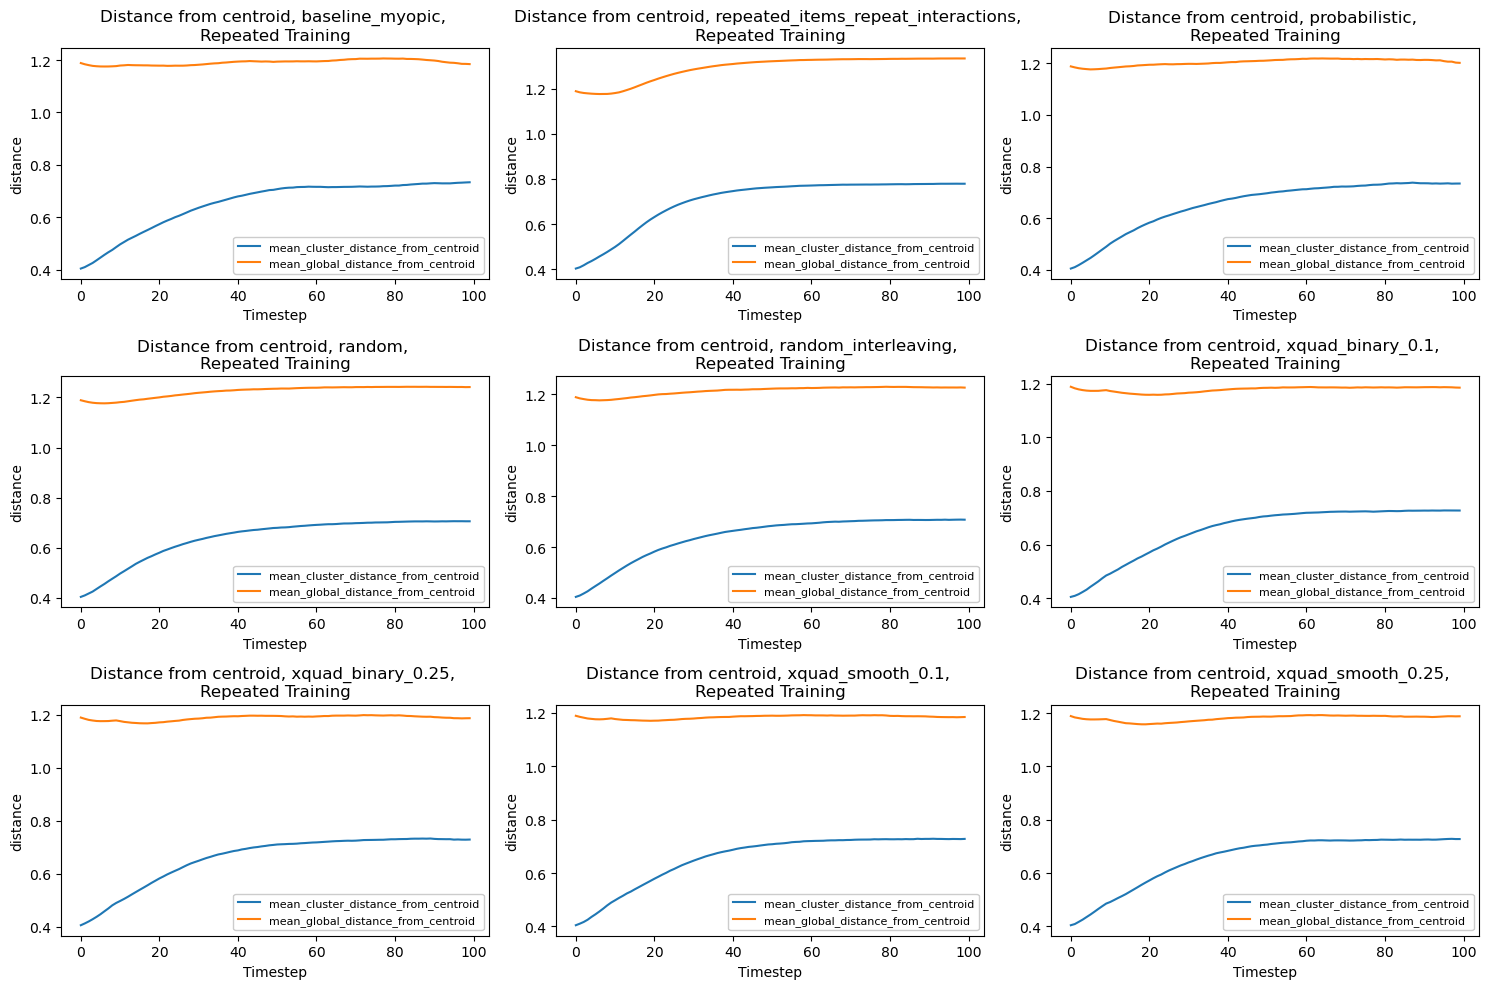

In [21]:
# Repeated training
title = "Distance from centroid"
metric_keys = ["mean_cluster_distance_from_centroid", "mean_global_distance_from_centroid"]
training_type = "Repeated Training"

num_plots = len(model_keys)
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, model_key in enumerate(model_keys):
    curr_ax = axs[int(i/3), i%3]
    # print(model_key)
    graph_metrics_by_axis(curr_ax, repeated_training_results, metric_keys[0], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    graph_metrics_by_axis(curr_ax, repeated_training_results, metric_keys[1], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    # graph_metrics_by_axis(curr_ax, repeated_training_results, metric_keys[2], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    
    curr_ax.set_ylabel(y_labels[metric_keys[0]])
    curr_ax.set_xlabel("Timestep")
    # curr_ax.set_xlim(50, 100)
    curr_ax.set_title(f"{title}, {model_key}, \n{training_type}")
    curr_ax.legend(facecolor='white', framealpha=1, loc='best', fontsize="8",)

plt.tight_layout()

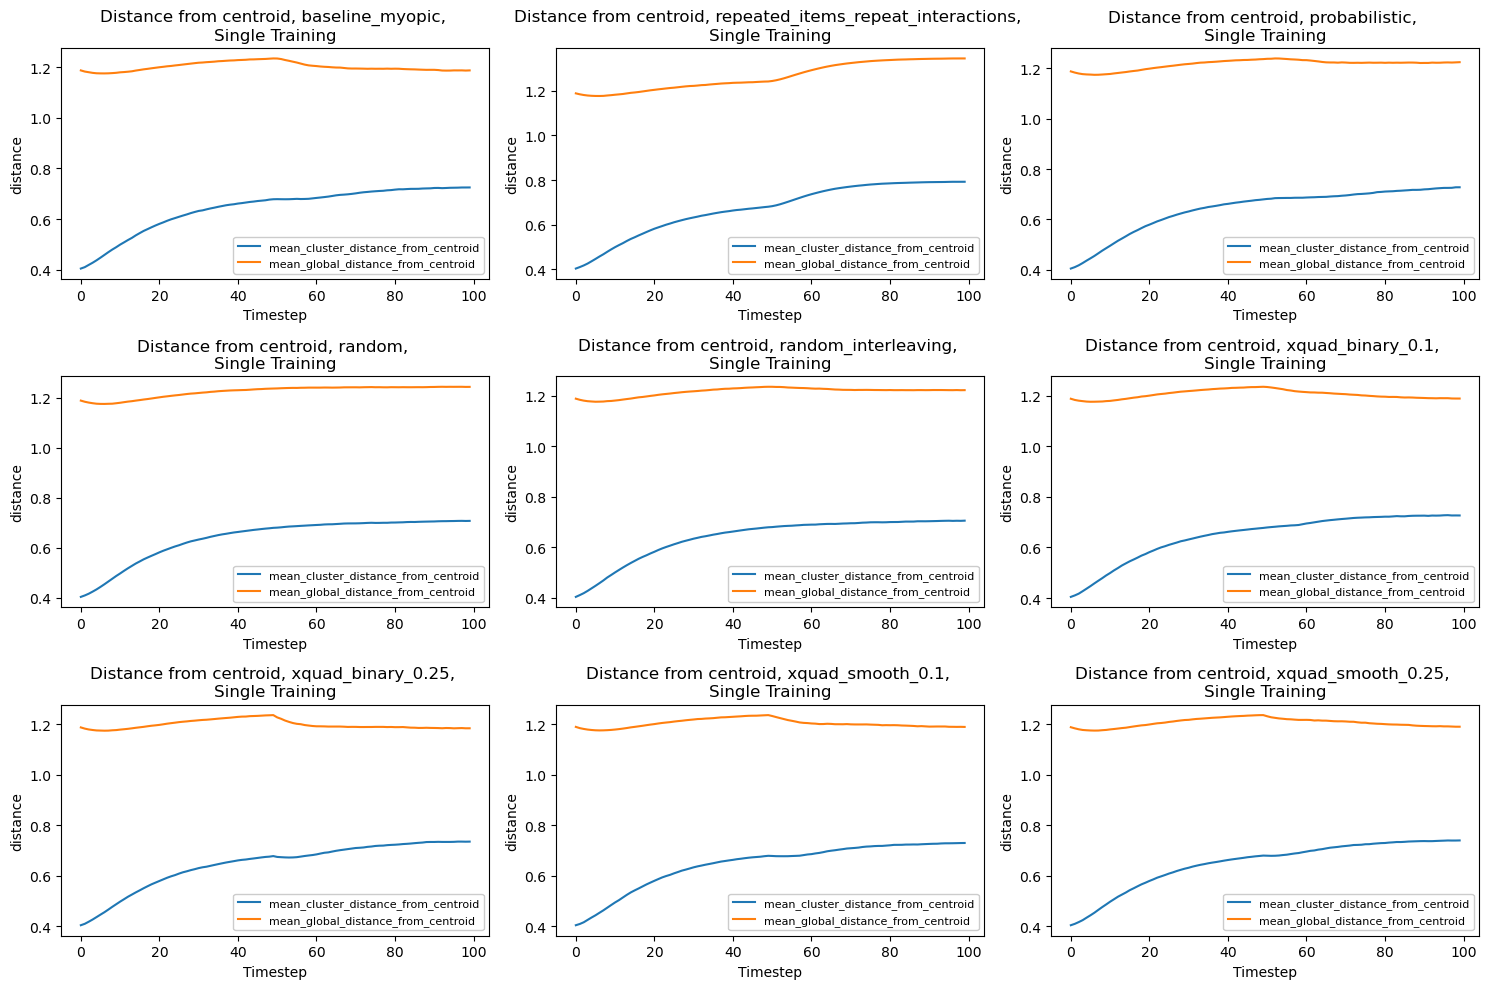

In [22]:
# Single training
title = "Distance from centroid"
metric_keys = ["mean_cluster_distance_from_centroid", "mean_global_distance_from_centroid"]
training_type = "Single Training"

num_plots = len(model_keys)
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, model_key in enumerate(model_keys):
    curr_ax = axs[int(i/3), i%3]
    # print(model_key)
    graph_metrics_by_axis(curr_ax, single_training_results, metric_keys[0], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    graph_metrics_by_axis(curr_ax, single_training_results, metric_keys[1], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    # graph_metrics_by_axis(curr_ax, repeated_training_results, metric_keys[2], [model_key], id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_metric")
    
    curr_ax.set_ylabel(y_labels[metric_keys[0]])
    curr_ax.set_xlabel("Timestep")
    # curr_ax.set_xlim(50, 100)
    curr_ax.set_title(f"{title}, {model_key}, \n{training_type}")
    curr_ax.legend(facecolor='white', framealpha=1, loc='best', fontsize="8",)

plt.tight_layout()

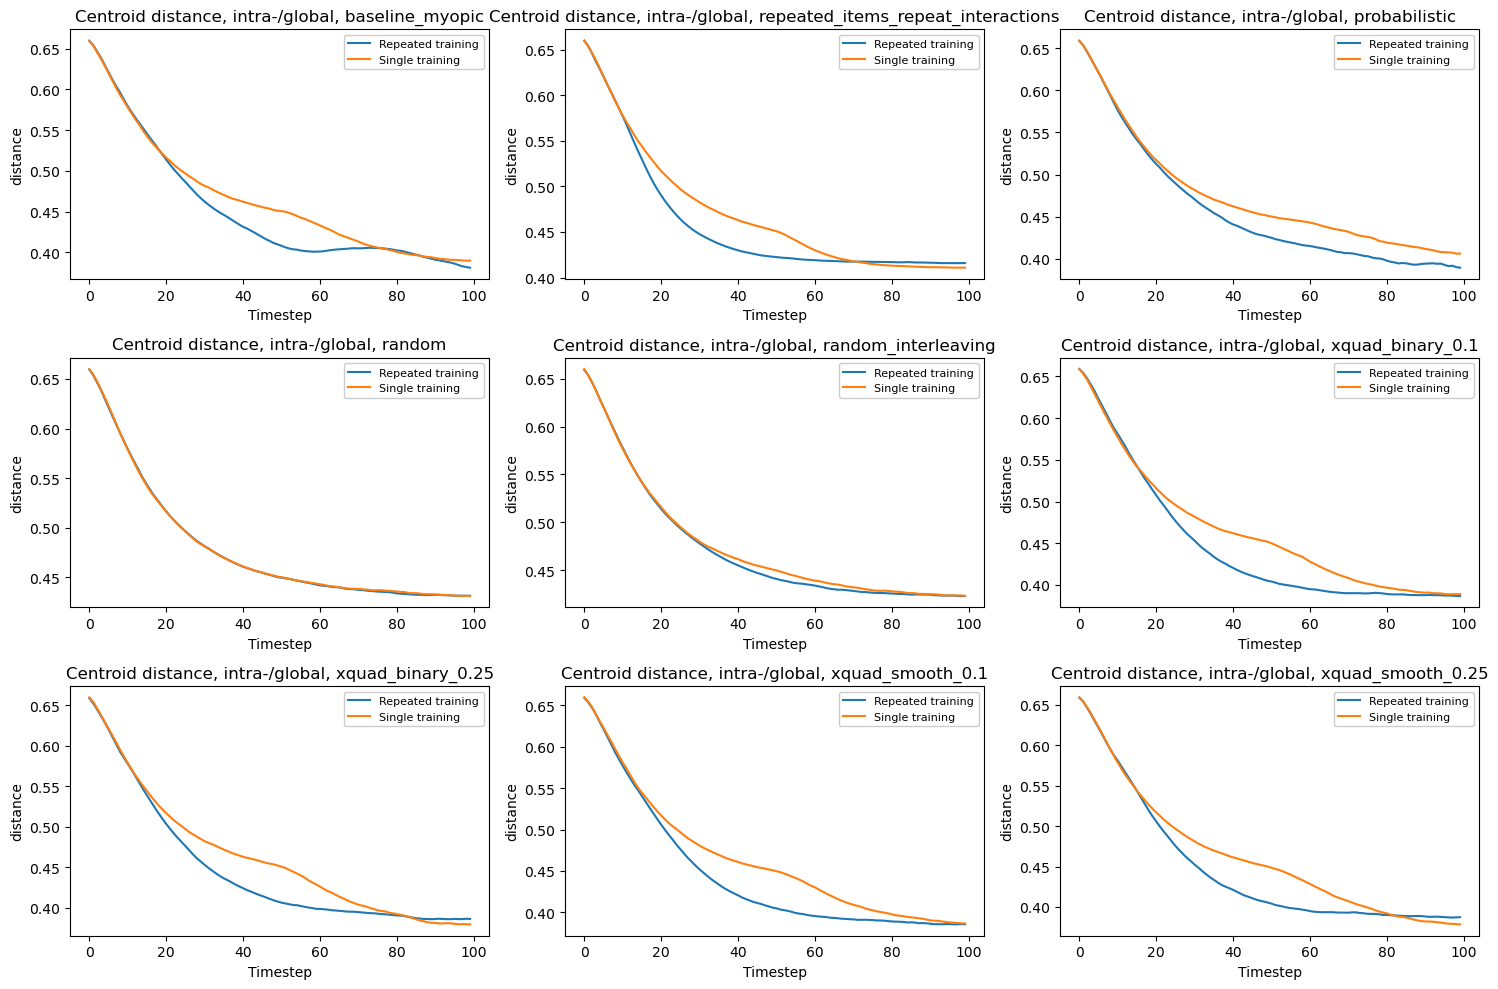

In [24]:
title = "Centroid distance, intra-/global"
numerator = "mean_global_distance_from_centroid"
denominator = "mean_cluster_distance_from_centroid"

num_plots = len(model_keys)
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, model_key in enumerate(model_keys):
    curr_ax = axs[int(i/3), i%3]
    graph_metrics_difference_by_axis(curr_ax, repeated_training_results, numerator, denominator, [model_key], id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, normalized=True, label="Repeated training")
    graph_metrics_difference_by_axis(curr_ax, single_training_results, numerator, denominator, [model_key], id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, normalized=True, label="Single training")
    curr_ax.set_ylabel(y_labels[numerator])
    curr_ax.set_xlabel("Timestep")
    # curr_ax.set_xlim(50, 100)
    curr_ax.set_title(f"{title}, {model_key}")
    curr_ax.legend(facecolor='white', framealpha=1, loc='best', fontsize="8",)

plt.tight_layout()

# graph_metrics_difference_by_axis(axs, repeated_training_results, numerator, denominator, model_keys, id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, normalized=False, label="by_params")
# axs.legend(facecolor='white', framealpha=1, loc='best', bbox_to_anchor=(0, 0))
# axs.plot(np.arange(100), np.zeros(100), linestyle='dashed')

# plt.tight_layout()

# Graphing `novelty`

In [55]:
def graph_novelty(train_results, metric_key, model_keys, label_map, mean_sigma=0, mult_sd=0, conf_sigma=0, begin_timesteps=0):
    for m in model_keys:
        if not isinstance(train_results[metric_key][m], np.ndarray):
            train_results[metric_key][m] = np.array(train_results[metric_key][m])
        # average across trials and smooth, if necessary
        if mean_sigma > 0:
            values = gaussian_filter1d(train_results[metric_key][m][begin_timesteps:].mean(axis=0), sigma=mean_sigma)
        else:
            values = train_results[metric_key][m][:, begin_timesteps:].mean(axis=0)
        line = plt.plot(values, label=label_map[m])
        line_color = line[0].get_color()
        if mult_sd > 0:
            std = train_results[metric_key][m][begin_timesteps:].std(axis=0)
            timesteps = np.arange(len(std))
            low = values - mult_sd * std
            high = values + mult_sd * std
            if conf_sigma > 0:
                low = gaussian_filter1d(low, sigma=conf_sigma)
                high = gaussian_filter1d(high, sigma=conf_sigma)
            plt.fill_between(timesteps, low, high, color = line_color, alpha=0.3)
    plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
    
def graph_novelty_by_axis(ax, train_results, metric_key, model_keys, label_map, mean_sigma=0, mult_sd=0, conf_sigma=0, label="by_params", begin_timesteps=50):
    for m in model_keys:
        if not isinstance(train_results[metric_key][m], np.ndarray):
            train_results[metric_key][m] = np.array(train_results[metric_key][m])
        # average across trials and smooth, if necessary
        # if mean_sigma > 0:
        #     values = gaussian_filter1d(train_results[metric_key][m][:, begin_timesteps:].mean(axis=0), sigma=mean_sigma)
        # else:
        values = train_results[metric_key][m][:, begin_timesteps:].mean(axis=0)
        if label == "by_params":
            line_label = label_map[m]
        elif label == "by_metric":
            line_label = metric_key
        else:
            line_label = label
        line = ax.plot(values, label=line_label)
        line_color = line[0].get_color()
        # if mult_sd > 0:
        #     std = train_results[metric_key][m][:, begin_timesteps:].std(axis=0)
        #     timesteps = np.arange(len(std))
        #     low = values - mult_sd * std
        #     high = values + mult_sd * std
        #     if conf_sigma > 0:
        #         low = gaussian_filter1d(low, sigma=conf_sigma)
        #         high = gaussian_filter1d(high, sigma=conf_sigma)
        #     ax.fill_between(timesteps, low, high, color = line_color, alpha=0.3)
    ax.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.5))
    return ax

Text(0.5, 1.0, 'mean_novelty, Repeated Training')

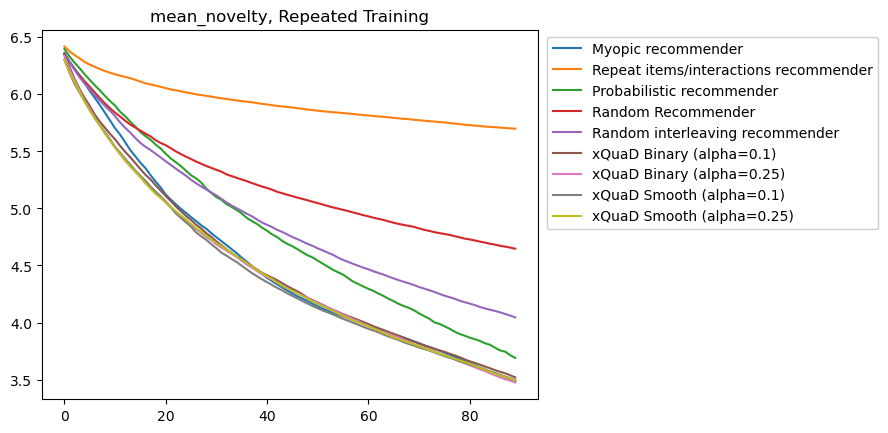

In [56]:
# Repeated training
metric_key = "mean_novelty"
training_type = "Repeated Training"

graph_novelty(repeated_training_results, metric_key, model_keys, id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, begin_timesteps=10)
plt.title(f"{metric_key}, {training_type}")
# for model in repeated_training_results["mean_novelty"]:
#     for sim_num in range(len(repeated_training_results["mean_novelty"][model])):
#         if not np.all(repeated_training_results["mean_novelty"][model][sim_num][10:]):
#             print(model, sim_num)
            # print(np.where(repeated_training_results["mean_novelty"][model][sim_num] < 0))

Text(0.5, 1.0, 'mean_novelty, Single Training')

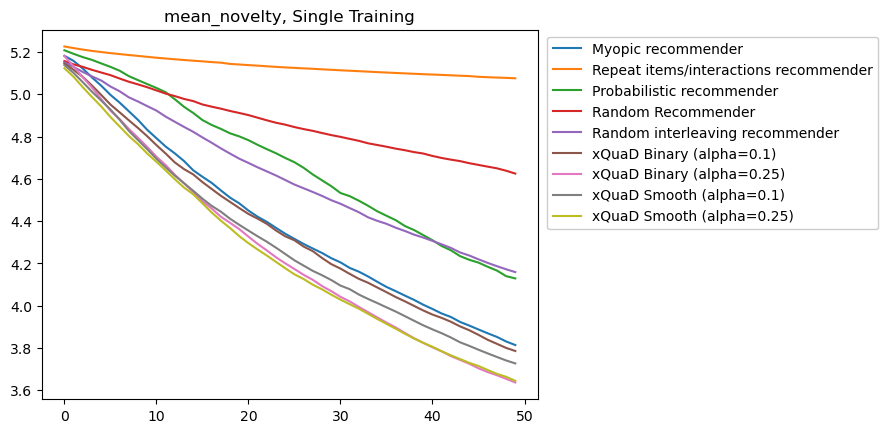

In [57]:
# Single training
metric_key = "mean_novelty"
training_type = "Single Training"

graph_novelty(single_training_results, metric_key, model_keys, id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0, begin_timesteps=50)
plt.title(f"{metric_key}, {training_type}")
# for model in repeated_training_results["mean_novelty"]:
#     for sim_num in range(len(repeated_training_results["mean_novelty"][model])):
#         if not np.all(repeated_training_results["mean_novelty"][model][sim_num][10:]):
#             print(model, sim_num)
            # print(np.where(repeated_training_results["mean_novelty"][model][sim_num] < 0))

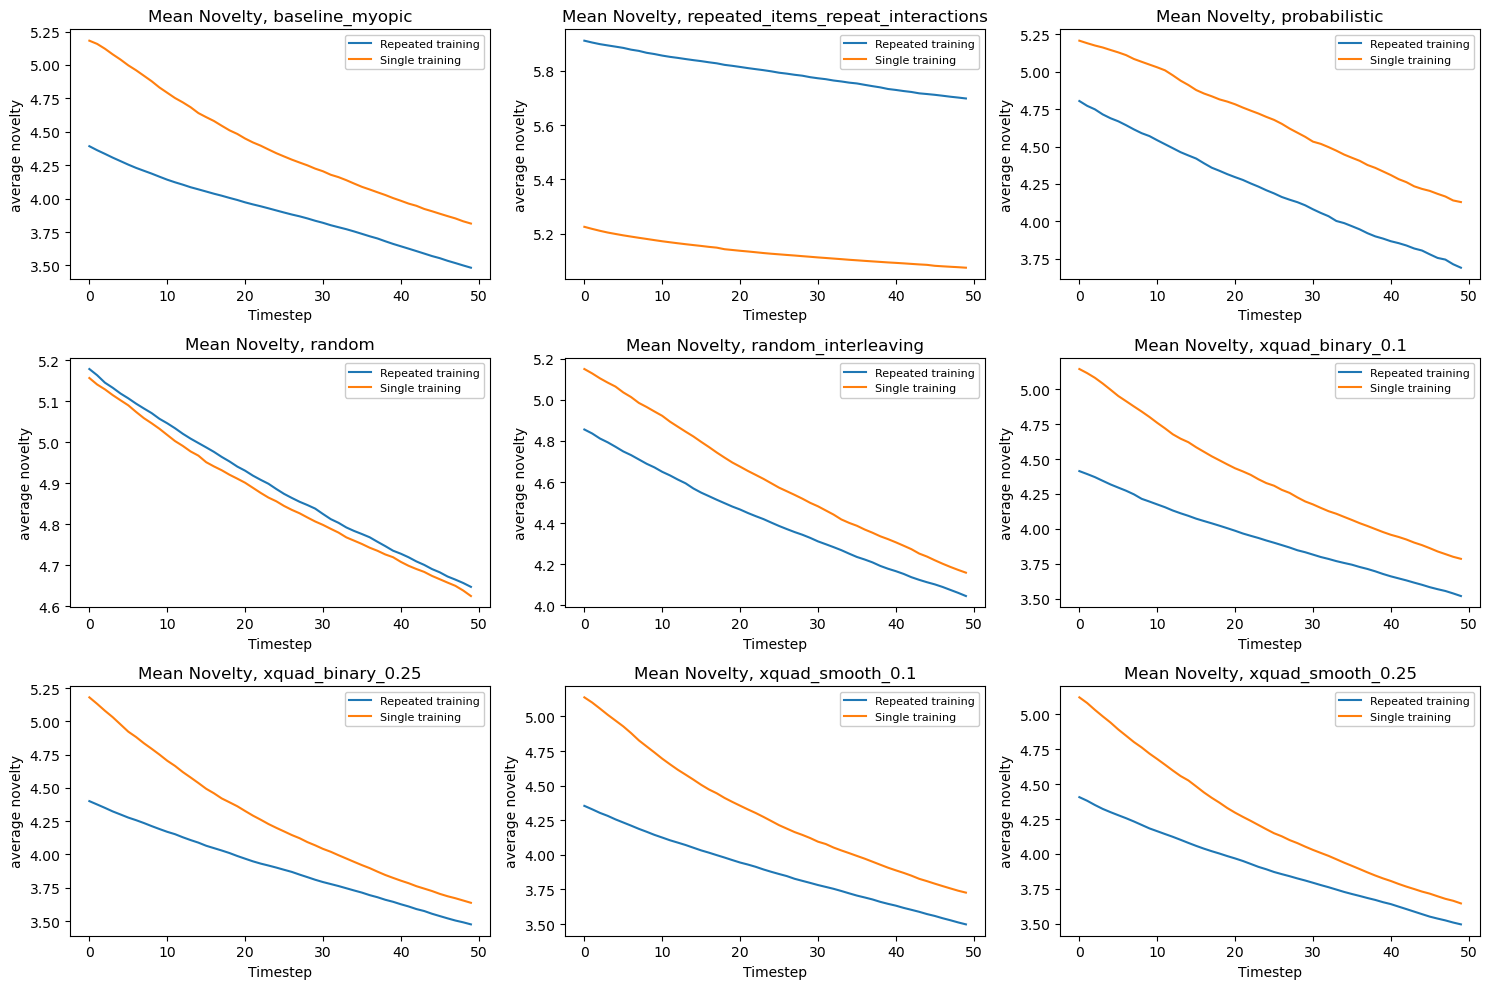

In [58]:
title = "Mean Novelty"
metric = "mean_novelty"

num_plots = len(model_keys)
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, model_key in enumerate(model_keys):
    curr_ax = axs[int(i/3), i%3]
    
    graph_novelty_by_axis(curr_ax, repeated_training_results, metric, [model_key], id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, label="Repeated training")
    graph_novelty_by_axis(curr_ax, single_training_results, metric, [model_key], id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, label="Single training")
    curr_ax.set_ylabel(y_labels[metric])
    curr_ax.set_xlabel("Timestep")
    # curr_ax.set_xlim(50, 100)
    curr_ax.set_title(f"{title}, {model_key}")
    curr_ax.legend(facecolor='white', framealpha=1, loc='best', fontsize="8",)

plt.tight_layout()

# graph_metrics_difference_by_axis(axs, repeated_training_results, numerator, denominator, model_keys, id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, normalized=False, label="by_params")
# axs.legend(facecolor='white', framealpha=1, loc='best', bbox_to_anchor=(0, 0))
# axs.plot(np.arange(100), np.zeros(100), linestyle='dashed')

# plt.tight_layout()

# Graphing `slate topic diversity`

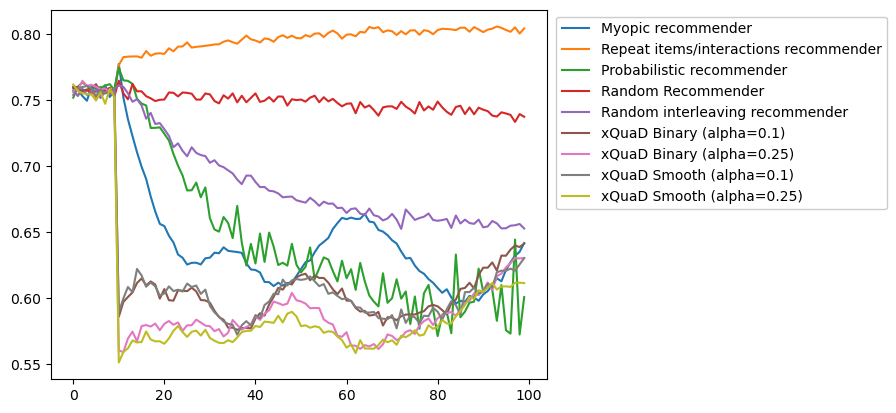

In [60]:
metric_key = "mean_slate_topic_diversity"

graph_metrics(repeated_training_results, metric_key, model_keys, id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0)

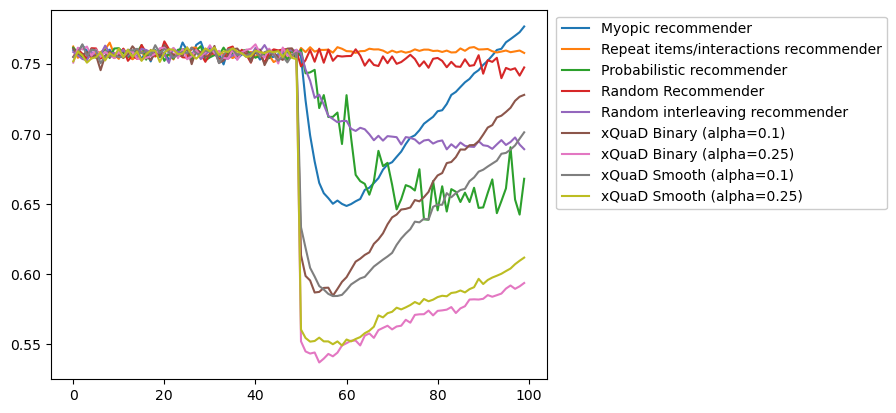

In [61]:
metric_key = "mean_slate_topic_diversity"

graph_metrics(single_training_results, metric_key, model_keys, id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0)

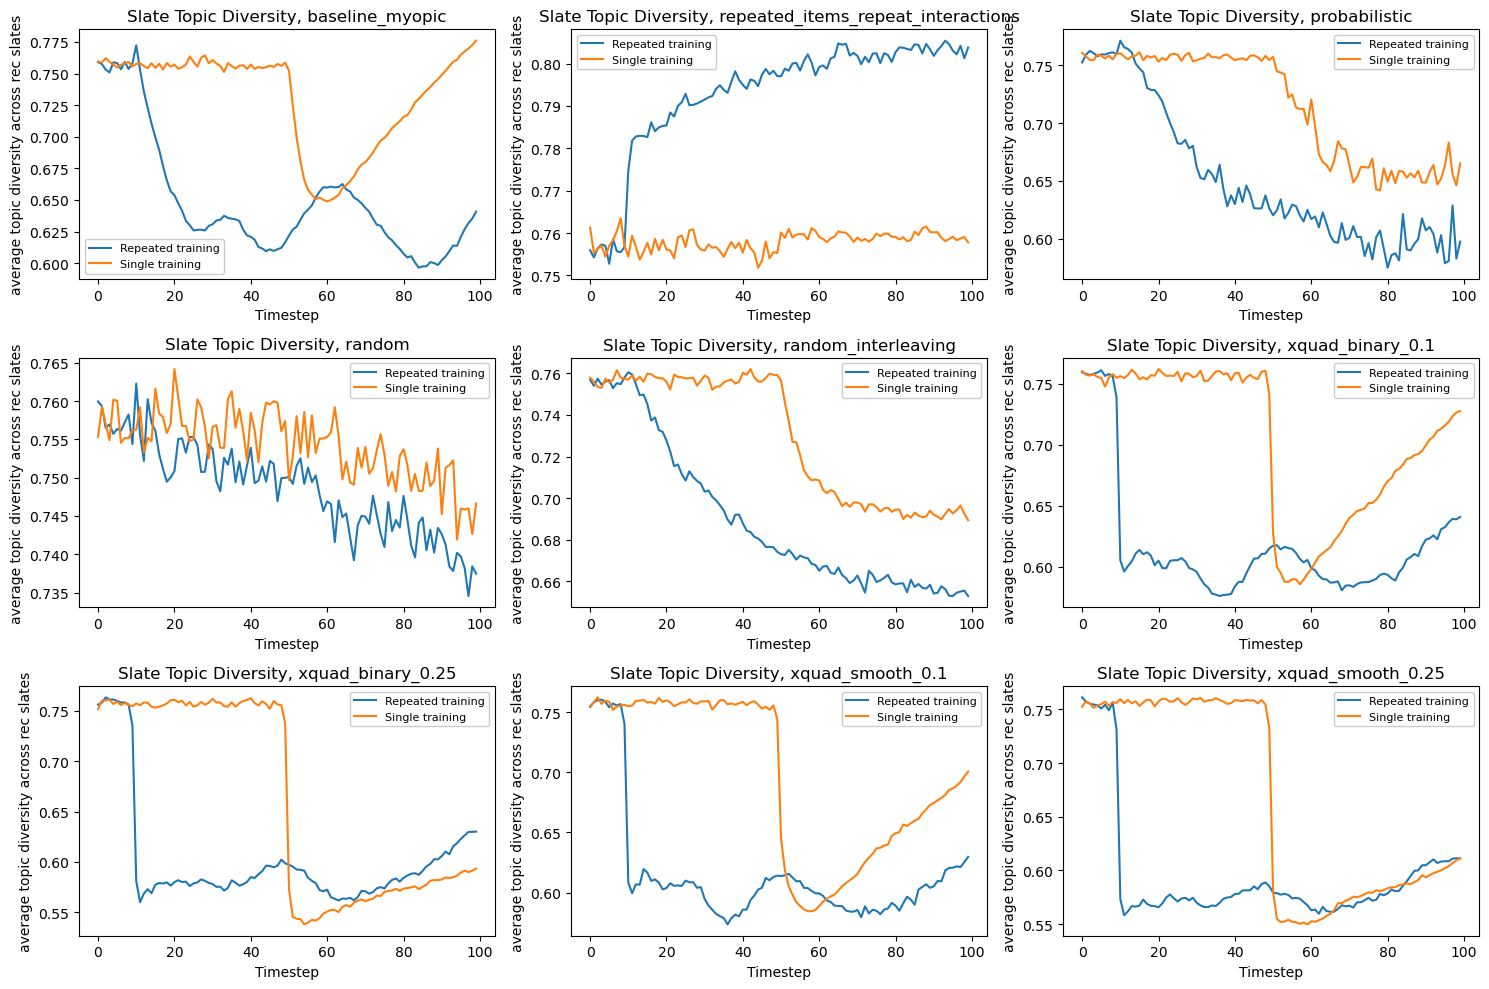

In [62]:
title = "Slate Topic Diversity"
metric = "mean_slate_topic_diversity"

num_plots = len(model_keys)
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, model_key in enumerate(model_keys):
    curr_ax = axs[int(i/3), i%3]
    
    graph_metrics_by_axis(curr_ax, repeated_training_results, metric, [model_key], id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, label="Repeated training")
    graph_metrics_by_axis(curr_ax, single_training_results, metric, [model_key], id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, label="Single training")
    curr_ax.set_ylabel(y_labels[metric])
    curr_ax.set_xlabel("Timestep")
    # curr_ax.set_xlim(50, 100)
    curr_ax.set_title(f"{title}, {model_key}")
    curr_ax.legend(facecolor='white', framealpha=1, loc='best', fontsize="8",)

plt.tight_layout()

# graph_metrics_difference_by_axis(axs, repeated_training_results, numerator, denominator, model_keys, id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, normalized=False, label="by_params")
# axs.legend(facecolor='white', framealpha=1, loc='best', bbox_to_anchor=(0, 0))
# axs.plot(np.arange(100), np.zeros(100), linestyle='dashed')

# plt.tight_layout()

# Graphing `interaction spread`

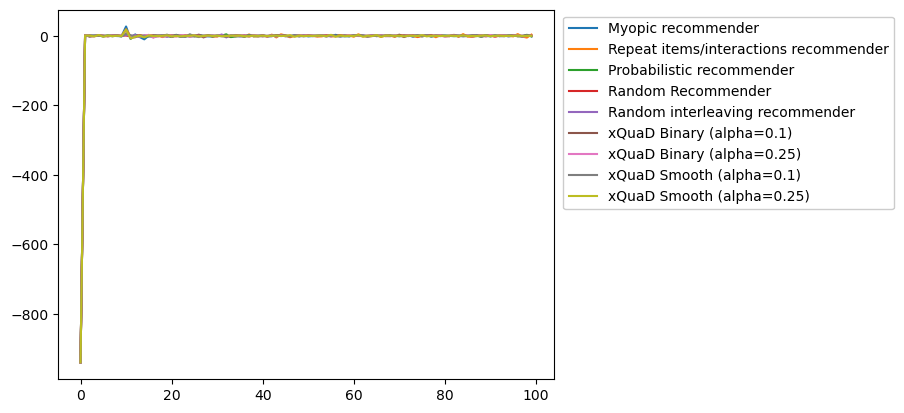

In [63]:
metric_key = "interaction_spread"

graph_metrics(repeated_training_results, metric_key, model_keys, id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0)

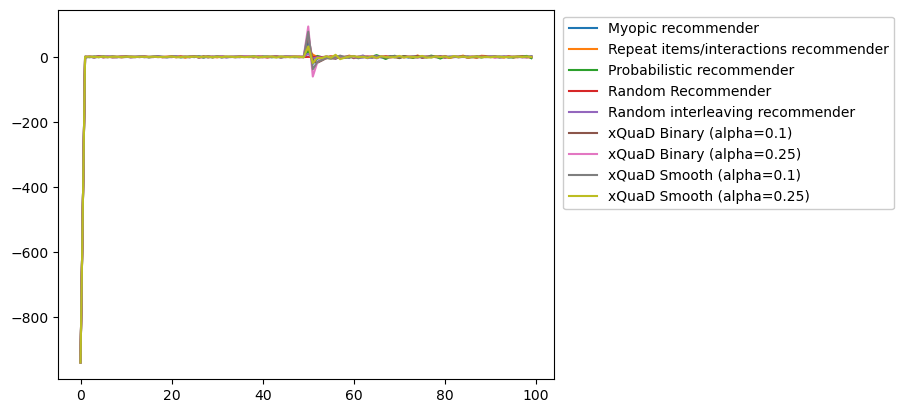

In [64]:
metric_key = "interaction_spread"

graph_metrics(single_training_results, metric_key, model_keys, id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0)

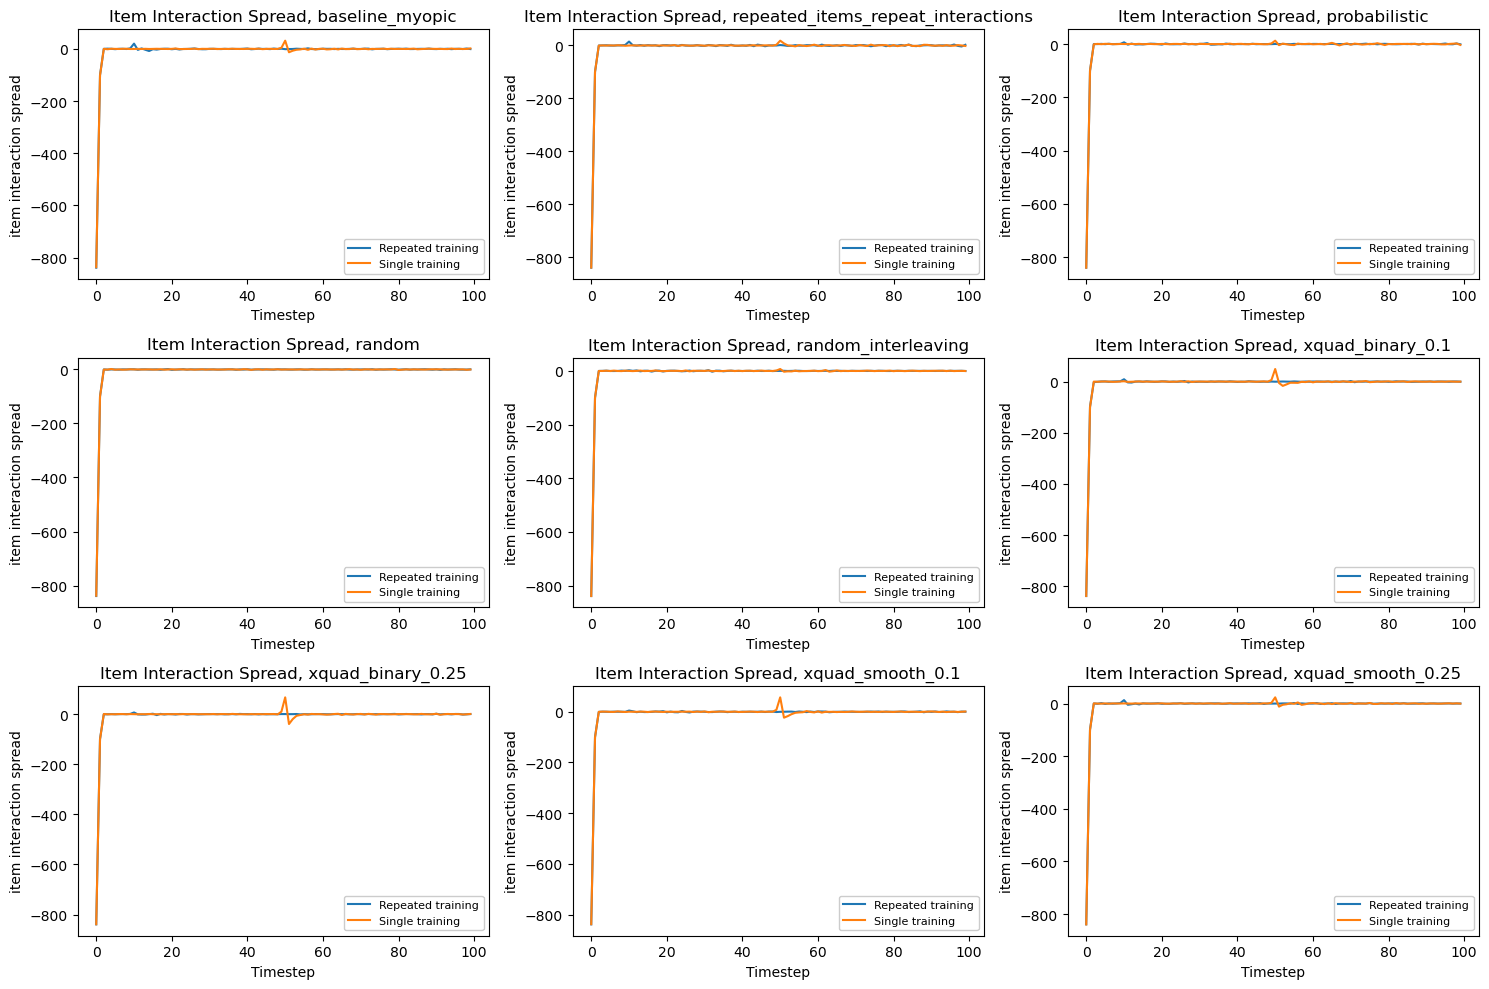

In [65]:
title = "Item Interaction Spread"
metric = "interaction_spread"

num_plots = len(model_keys)
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, model_key in enumerate(model_keys):
    curr_ax = axs[int(i/3), i%3]
    
    graph_metrics_by_axis(curr_ax, repeated_training_results, metric, [model_key], id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, label="Repeated training")
    graph_metrics_by_axis(curr_ax, single_training_results, metric, [model_key], id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, label="Single training")
    curr_ax.set_ylabel(y_labels[metric])
    curr_ax.set_xlabel("Timestep")
    # curr_ax.set_xlim(50, 100)
    curr_ax.set_title(f"{title}, {model_key}")
    curr_ax.legend(facecolor='white', framealpha=1, loc='best', fontsize="8",)

plt.tight_layout()

# graph_metrics_difference_by_axis(axs, repeated_training_results, numerator, denominator, model_keys, id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, normalized=False, label="by_params")
# axs.legend(facecolor='white', framealpha=1, loc='best', bbox_to_anchor=(0, 0))
# axs.plot(np.arange(100), np.zeros(100), linestyle='dashed')

# plt.tight_layout()

# Graphing `topic interaction spread`

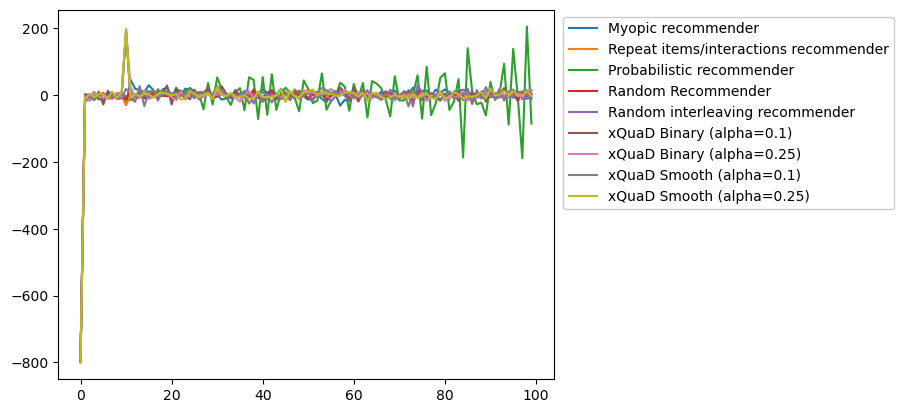

In [66]:
metric_key = "topic_interaction_spread"

graph_metrics(repeated_training_results, metric_key, model_keys, id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0)

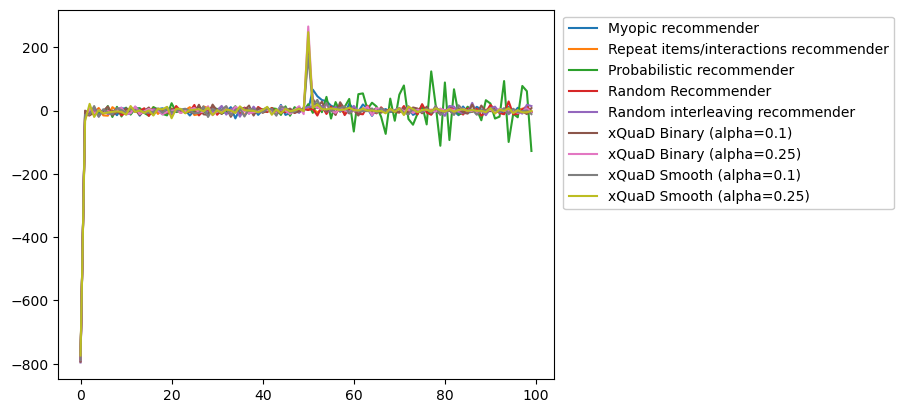

In [67]:
metric_key = "topic_interaction_spread"

graph_metrics(single_training_results, metric_key, model_keys, id_to_readable, mean_sigma=0, mult_sd=0, conf_sigma=0)

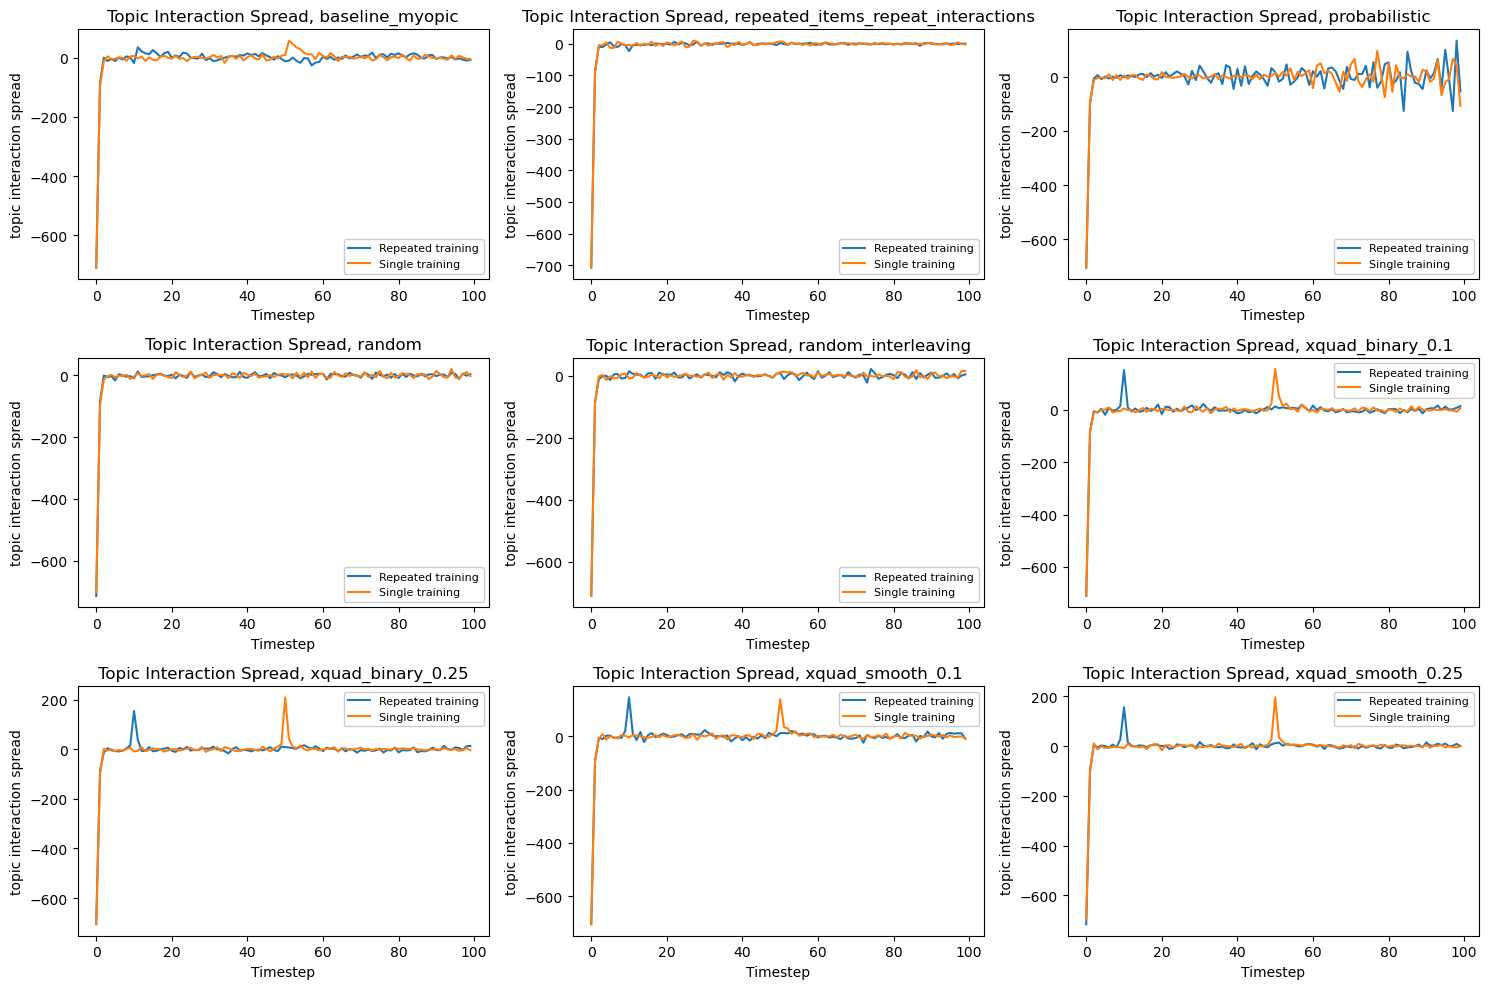

In [68]:
title = "Topic Interaction Spread"
metric = "topic_interaction_spread"

num_plots = len(model_keys)
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, model_key in enumerate(model_keys):
    curr_ax = axs[int(i/3), i%3]
    
    graph_metrics_by_axis(curr_ax, repeated_training_results, metric, [model_key], id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, label="Repeated training")
    graph_metrics_by_axis(curr_ax, single_training_results, metric, [model_key], id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, label="Single training")
    curr_ax.set_ylabel(y_labels[metric])
    curr_ax.set_xlabel("Timestep")
    # curr_ax.set_xlim(50, 100)
    curr_ax.set_title(f"{title}, {model_key}")
    curr_ax.legend(facecolor='white', framealpha=1, loc='best', fontsize="8",)

plt.tight_layout()

# graph_metrics_difference_by_axis(axs, repeated_training_results, numerator, denominator, model_keys, id_to_readable, mean_sigma=0.5, mult_sd=0, conf_sigma=0, normalized=False, label="by_params")
# axs.legend(facecolor='white', framealpha=1, loc='best', bbox_to_anchor=(0, 0))
# axs.plot(np.arange(100), np.zeros(100), linestyle='dashed')

# plt.tight_layout()

In [13]:
hyper_params = {
    "drift":0.1,
    "attention_exp":-0.8,
    "num_clusters":15,
    "num_attrs":20,
    "max_iter":1000
}

data_path = '/Users/madisonthantu/Desktop/DREAM/data/ml-100k/u.data'

binary_ratings_matrix = load_and_process_movielens(file_path=data_path)
user_representation, item_representation = compute_embeddings(binary_ratings_matrix, n_attrs=hyper_params["num_attrs"], max_iter=hyper_params["max_iter"])
# Define topic clusters using NMF
item_cluster_ids, item_cluster_centers = compute_constrained_clusters(embeddings=item_representation.T, name='item_clusters', n_clusters=hyper_params["num_clusters"])
user_cluster_ids, user_cluster_centers = compute_constrained_clusters(embeddings=user_representation, name='user_clusters', n_clusters=hyper_params["num_clusters"])
global_user_cluster_ids, global_user_cluster_centers = compute_constrained_clusters(embeddings=user_cluster_centers, name='global_user_clusters', n_clusters=1)
# Get user pairs - global user pairs, intra-cluster user pairs, inter-cluster user pairs
global_user_pairs = create_global_user_pairs(user_cluster_ids)
user_item_cluster_mapping = user_topic_mapping(user_representation, item_cluster_centers)
inter_cluster_user_pairs, intra_cluster_user_pairs = create_cluster_user_pairs(user_item_cluster_mapping)
        
users = Users(
    actual_user_profiles=user_representation, 
    drift=hyper_params["drift"],
    attention_exp=hyper_params["attention_exp"],
    repeat_interactions=0,  # ********** #
)
baseline_myopic = BubbleBurster(
    actual_user_representation=users, 
    num_attributes=hyper_params["num_attrs"],
    num_items_per_iter=10,
    record_base_state=True,
    actual_item_representation=item_representation,
    item_topics=item_cluster_ids,
    probabilistic_recommendations=0     # ********** #
)

from wrapper.metrics.evaluation_metrics import DiversityMetric, NoveltyMetric, TopicInteractionMeasurement, TopicInteractionSpread, UserMSEMeasurement
metrics = [
        MSEMeasurement(diagnostics=True),  
        InteractionSpread(),                
        InteractionSimilarity(pairs=global_user_pairs, name='global_interaction_similarity', diagnostics=True), 
        InteractionSimilarity(pairs=inter_cluster_user_pairs, name='inter_cluster_interaction_similarity', diagnostics=True), 
        InteractionSimilarity(pairs=intra_cluster_user_pairs, name='intra_cluster_interaction_similarity', diagnostics=True), 
        MeanCosineSim(pairs=global_user_pairs, name='mean_global_cosine_sim', diagnostics=True),
        MeanCosineSim(pairs=intra_cluster_user_pairs, name='mean_intra_cluster_cosine_sim', diagnostics=True),
        MeanCosineSim(pairs=inter_cluster_user_pairs, name='mean_inter_cluster_cosine_sim', diagnostics=True),
        MeanCosineSimPerCluster(user_cluster_ids=user_cluster_ids, n_clusts=hyper_params["num_clusters"], name="mean_cosine_sim_per_cluster", diagnostics=True), 
        MeanDistanceFromCentroid(user_cluster_ids=user_cluster_ids, user_centroids=user_cluster_centers, name="mean_cluster_distance_from_centroid", diagnostics=True), 
        MeanDistanceFromCentroid(user_cluster_ids=global_user_cluster_ids, user_centroids=global_user_cluster_centers, name="mean_global_distance_from_centroid", diagnostics=True), 
        MeanDistanceFromCentroidPerCluster(user_cluster_ids=user_cluster_ids, user_centroids=user_cluster_centers, n_clusts=hyper_params["num_clusters"], name="mean_distance_from_centroid_per_cluster", diagnostics=True),
        InteractionMeasurement(name="interaction_histogram"),
        RMSEMeasurement(),
        NoveltyMetric(diagnostics=True),
        DiversityMetric(),
        TopicInteractionMeasurement(),
        TopicInteractionSpread(),
        UserMSEMeasurement()
    ]

baseline_myopic.add_metrics(*metrics)
baseline_myopic.startup_and_train(timesteps=10)
baseline_myopic.run(
    timesteps=90, 
    train_between_steps=1, 
    repeated_items=0,       # ********** #
    random_items_per_iter=0 # ********** #
)
baseline_myopic.close() # end logging


100%|██████████| 90/90 [15:38<00:00, 10.42s/it]


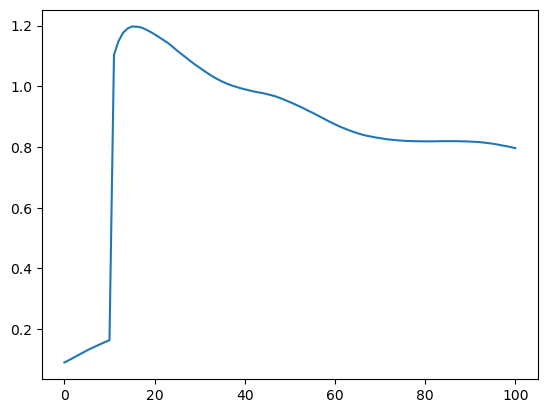

In [15]:
test_results = baseline_myopic.get_measurements()
plt.plot(test_results['mse'])